Steps:

1. Load the data.
2. Cast text to lower case.
3. Eliminate punctuation.
4. Get the maximum number of tokens in the data.
5. Tokenize the data.

In [1]:
import string
import os
import matplotlib.pyplot as plt
from jupyterthemes import jtplot

import pandas as pd
import numpy as np

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from unidecode import unidecode

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
device

device(type='cuda')

In [4]:
jtplot.style('gruvboxd')

In [5]:
### Reproducibility
torch.manual_seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

In [6]:
BATCH_SIZE = 32
SEQ_LEN = 400

In [7]:
DATA_PATH = os.path.join(os.getcwd().replace('notebooks', 'data'), 'train.csv')

In [8]:
data = pd.read_csv(DATA_PATH)

In [9]:
data.head()

,lyric,class
0,Can't drink without thinkin' about you,1
1,Now Lil Pump flyin' private jet (Yuh),0
2,"No, matter fact, you ain't help me when I had ...",0
3,"And you could find me, I ain't hidin'",0
4,From the way you talk to the way you move,1


In [10]:
data['lyric'] = data['lyric'].str.lower()

In [11]:
data.head()

,lyric,class
0,can't drink without thinkin' about you,1
1,now lil pump flyin' private jet (yuh),0
2,"no, matter fact, you ain't help me when i had ...",0
3,"and you could find me, i ain't hidin'",0
4,from the way you talk to the way you move,1


In [12]:
def clear_punctuation(text):
    text = ''.join([char for char in text if char not in all_punct])
    return text

In [13]:
all_char = string.ascii_lowercase + string.digits

In [14]:
all_char

'abcdefghijklmnopqrstuvwxyz0123456789'

In [15]:
all_punct = string.punctuation

In [16]:
all_punct

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [17]:
data['lyric'] = data['lyric'].apply(clear_punctuation)

In [18]:
data.head()

,lyric,class
0,cant drink without thinkin about you,1
1,now lil pump flyin private jet yuh,0
2,no matter fact you aint help me when i had no ...,0
3,and you could find me i aint hidin,0
4,from the way you talk to the way you move,1


In [19]:
data['lyric_len'] = data['lyric'].apply(len)

In [20]:
data.head()

,lyric,class,lyric_len
0,cant drink without thinkin about you,1,36
1,now lil pump flyin private jet yuh,0,34
2,no matter fact you aint help me when i had no ...,0,51
3,and you could find me i aint hidin,0,34
4,from the way you talk to the way you move,1,41


In [21]:
data.loc[data['lyric_len'] == max(data['lyric_len'])]

,lyric,class,lyric_len
41158,although the recent concerts of some of the bi...,0,345


In [22]:
for row in data.iterrows():
    print(row[1])
    break

lyric        cant drink without thinkin about you
class                                           1
lyric_len                                      36
Name: 0, dtype: object


The length of the texts are not symmetrical, so we need to pad the text.

In [23]:
def pad_text(text, unk = '?', limit = 400):
    if len(text) < limit:
        text = text + unk*(limit - len(text))
    else:
        text = text[:limit-1]
    return text

In [24]:
data['lyric'] = data['lyric'].apply(pad_text, **{"limit" : SEQ_LEN, "unk" : "#"})

In [25]:
data.head()

,lyric,class,lyric_len
0,cant drink without thinkin about you##########...,1,36
1,now lil pump flyin private jet yuh############...,0,34
2,no matter fact you aint help me when i had no ...,0,51
3,and you could find me i aint hidin############...,0,34
4,from the way you talk to the way you move#####...,1,41


In [26]:
unidecode(data['lyric'][0])

'cant drink without thinkin about you############################################################################################################################################################################################################################################################################################################################################################################'

In [27]:
### Unique characters represented in the text
set(''.join(data['lyric'].tolist()))

{' ',
 '#',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

In [28]:
### Account for space and trhe unknown token (#)
all_char = '#' + ' ' + all_char

In [29]:
all_char

'# abcdefghijklmnopqrstuvwxyz0123456789'

In [30]:
char_dict = dict(enumerate(all_char, start = 0))
char_dict = {v: k for k, v in char_dict.items()}

In [31]:
char_dict

{'#': 0,
 ' ': 1,
 'a': 2,
 'b': 3,
 'c': 4,
 'd': 5,
 'e': 6,
 'f': 7,
 'g': 8,
 'h': 9,
 'i': 10,
 'j': 11,
 'k': 12,
 'l': 13,
 'm': 14,
 'n': 15,
 'o': 16,
 'p': 17,
 'q': 18,
 'r': 19,
 's': 20,
 't': 21,
 'u': 22,
 'v': 23,
 'w': 24,
 'x': 25,
 'y': 26,
 'z': 27,
 '0': 28,
 '1': 29,
 '2': 30,
 '3': 31,
 '4': 32,
 '5': 33,
 '6': 34,
 '7': 35,
 '8': 36,
 '9': 37}

In [32]:
class TextDataset(Dataset):
    def __init__(self, file):
        self.file = file
        self.texts = self.file['lyric']
        self.labels = self.file['class']
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, ix):
        return torch.tensor([char_dict[c] for c in unidecode(self.texts[ix])]), self.labels[ix]

In [33]:
text_data = TextDataset(data)

In [34]:
len(text_data)

51054

In [35]:
text_data.texts

0        cant drink without thinkin about you##########...
1        now lil pump flyin private jet yuh############...
2        no matter fact you aint help me when i had no ...
3        and you could find me i aint hidin############...
4        from the way you talk to the way you move#####...
                               ...                        
51049    i told her pour me some more then she went rig...
51050    hit the ground and crawl to the dresser#######...
51051    just keep breathin and breathin and breathin a...
51052    down go the system long live the king king####...
51053    if your mother knew all the things we do from ...
Name: lyric, Length: 51054, dtype: object

In [36]:
next(iter(text_data))

(tensor([ 4,  2, 15, 21,  1,  5, 19, 10, 15, 12,  1, 24, 10, 21,  9, 16, 22, 21,
          1, 21,  9, 10, 15, 12, 10, 15,  1,  2,  3, 16, 22, 21,  1, 26, 16, 22,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,

In [37]:
test_size = 5000
train_ds, test_ds = torch.utils.data.random_split(text_data, lengths = [len(text_data) - test_size, test_size])

In [38]:
len(train_ds)

46054

In [39]:
len(test_ds)

5000

In [40]:
train_dl = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

In [41]:
test_dl = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

In [42]:
next(iter(test_dl))

[tensor([[ 5, 16, 15,  ...,  0,  0,  0],
         [ 7,  2,  4,  ...,  0,  0,  0],
         [10,  1, 12,  ...,  0,  0,  0],
         ...,
         [14,  2, 26,  ...,  0,  0,  0],
         [16, 15, 13,  ...,  0,  0,  0],
         [24,  9,  2,  ...,  0,  0,  0]]),
 tensor([0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
         1, 1, 1, 1, 0, 0, 1, 1])]

In [43]:
class LyricModel(nn.Module):
    def __init__(self, batch_size = 32, num_layers = 2, hidden_size = 128, length = 64):
        self.hidden = hidden_size
        self.batch_size = batch_size
        self.length = length
        self.num_layers = num_layers
        
        super(LyricModel, self).__init__()
        
        self.embedder = nn.Embedding(num_embeddings = len(char_dict), embedding_dim = self.length)
        
        self.linear1 = nn.Linear(self.length, self.length*2)
        self.linear2 = nn.Linear(self.length*2, 1)
        self.linear3 = nn.Linear(SEQ_LEN, 1)
        
        self.dropout1 = nn.Dropout(p = 0.3)
        self.dropout2 = nn.Dropout(p = 0.5)
        
        self.b1 = nn.BatchNorm1d(400, momentum = 0.1)
        self.b2 = nn.BatchNorm1d(400, momentum = 0.1)
    
    def forward(self, x):
        y = self.embedder(x)
        y = self.b1(F.relu(self.linear1(y)))
        y = self.dropout1(y)
        y = self.b2(F.relu(self.linear2(y)))
        y = self.dropout2(y)
        y = y.view(-1, SEQ_LEN)
        return self.linear3(y)

In [44]:
def initialize_weights(model):
    for layer in model.modules():
        if 'Linear' in layer.__class__.__name__:
            nn.init.normal_(layer.weight, 0, 0.02)
            nn.init.normal_(layer.bias, 1, 0.02)
        elif 'BatchNorm' in layer.__class__.__name__:
            nn.init.normal_(layer.weight, 1, 0.02)
            nn.init.zeros_(layer.bias)
    return None

In [45]:
model = LyricModel(batch_size = BATCH_SIZE, hidden_size = 64, length = 32)

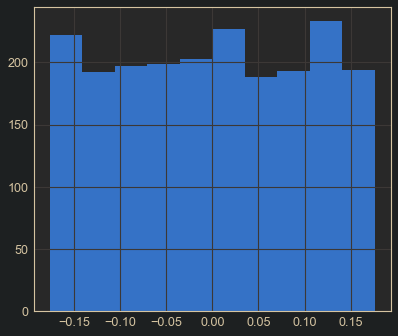

In [46]:
### Before weight initialization
plt.hist(torch.flatten(model.linear1.weight.data.detach().clone()).cpu().numpy())
plt.show()

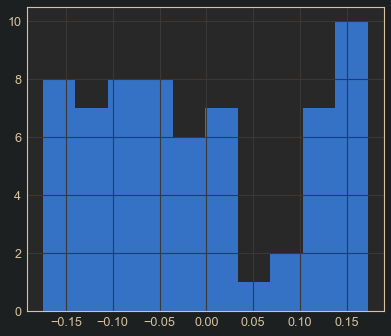

In [47]:
### Before weight initialization
plt.hist(torch.flatten(model.linear1.bias.data.detach().clone()).cpu().numpy())
plt.show()

In [48]:
### Initialize weignts and cast to device
model.apply(initialize_weights)
model.to(device)

LyricModel(
  (embedder): Embedding(38, 32)
  (linear1): Linear(in_features=32, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=1, bias=True)
  (linear3): Linear(in_features=400, out_features=1, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (b1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

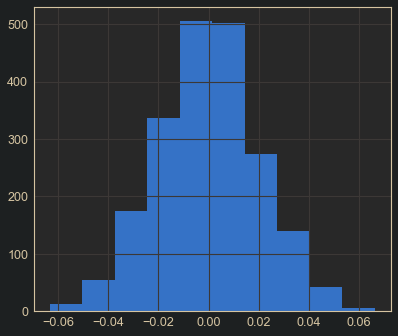

In [49]:
### After weight initialization
plt.hist(torch.flatten(model.linear1.weight.data.detach().clone()).cpu().numpy())
plt.show()

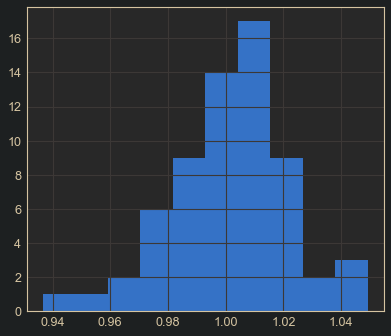

In [50]:
### After weight initialization
plt.hist(torch.flatten(model.linear1.bias.data.detach().clone()).cpu().numpy())
plt.show()

In [51]:
EPOCHS = 100
lr = 1e-4
betas = (0.5, 0.999)

In [52]:
opt = optim.Adam(params = model.parameters(), lr = lr, betas = betas)
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, 1200)
criterion = nn.BCEWithLogitsLoss().to(device)

In [53]:
final_test_loss = []
final_train_loss = []

final_test_acc = []
final_train_acc = []

for epoch in range(1, EPOCHS + 1):
    train_losses = list()
    train_accs = 0
    
    for i, (X, y) in enumerate(train_dl, start = 1):
        opt.zero_grad()
        model.train()
        
        X, y = X.cuda(), y.cuda()
        
        pred = model(X)
        loss = criterion(pred.squeeze(), y.float())
        
        loss.backward()
        opt.step()
        
        train_losses.append(loss.item())
        train_accs += torch.sum(torch.where(pred > 0.5, 1, 0).squeeze() == y).cpu().numpy()/len(y)
        
        if (i == len(train_dl)):
            train_loss = sum(train_losses)/len(train_dl)
            train_acc = train_accs/len(train_dl)
            
            test_losses = list()
            test_accs = 0
            
            with torch.no_grad():
                model.eval()
                for X_test, y_test in test_dl:
                    X_test, y_test = X_test.to(device), y_test.to(device)
                    test_pred = model(X_test)
                    test_loss = criterion(test_pred.squeeze(), y_test.float())
                    test_losses.append(test_loss.item())
                    test_accs += torch.sum(torch.where(test_pred > 0.5, 1, 0).squeeze() == y_test).cpu().numpy()/len(y_test)
                
                test_loss = sum(test_losses)/len(test_dl)
                test_acc = test_accs/len(test_dl)
                
                final_test_loss.append(test_loss)
                final_train_loss.append(train_loss)
                
                final_test_acc.append(test_acc)
                final_train_acc.append(train_acc)
                
            print(f"Epoch [{epoch}/{EPOCHS}]")
            print(f"   Iteration [{i}/{len(train_dl)}]")
            print(f" \tTrain loss : {train_loss: .3f} || Test loss : {test_loss: .3f}")
            print(f" \tTrain acc. : {train_acc: .3f} || Test acc. : {test_acc: .3f}")

Epoch [1/100]
   Iteration [1440/1440]
 	Train loss :  0.773 || Test loss :  0.655
 	Train acc. :  0.551 || Test acc. :  0.625
Epoch [2/100]
   Iteration [1440/1440]
 	Train loss :  0.679 || Test loss :  0.634
 	Train acc. :  0.597 || Test acc. :  0.604
Epoch [3/100]
   Iteration [1440/1440]
 	Train loss :  0.665 || Test loss :  0.632
 	Train acc. :  0.601 || Test acc. :  0.609
Epoch [4/100]
   Iteration [1440/1440]
 	Train loss :  0.656 || Test loss :  0.628
 	Train acc. :  0.604 || Test acc. :  0.610
Epoch [5/100]
   Iteration [1440/1440]
 	Train loss :  0.652 || Test loss :  0.628
 	Train acc. :  0.604 || Test acc. :  0.613
Epoch [6/100]
   Iteration [1440/1440]
 	Train loss :  0.649 || Test loss :  0.627
 	Train acc. :  0.604 || Test acc. :  0.607
Epoch [7/100]
   Iteration [1440/1440]
 	Train loss :  0.646 || Test loss :  0.626
 	Train acc. :  0.605 || Test acc. :  0.614
Epoch [8/100]
   Iteration [1440/1440]
 	Train loss :  0.648 || Test loss :  0.625
 	Train acc. :  0.604 || Tes

Epoch [66/100]
   Iteration [1440/1440]
 	Train loss :  0.641 || Test loss :  0.625
 	Train acc. :  0.601 || Test acc. :  0.595
Epoch [67/100]
   Iteration [1440/1440]
 	Train loss :  0.641 || Test loss :  0.625
 	Train acc. :  0.600 || Test acc. :  0.606
Epoch [68/100]
   Iteration [1440/1440]
 	Train loss :  0.640 || Test loss :  0.624
 	Train acc. :  0.603 || Test acc. :  0.598
Epoch [69/100]
   Iteration [1440/1440]
 	Train loss :  0.641 || Test loss :  0.625
 	Train acc. :  0.600 || Test acc. :  0.600
Epoch [70/100]
   Iteration [1440/1440]
 	Train loss :  0.640 || Test loss :  0.625
 	Train acc. :  0.603 || Test acc. :  0.600
Epoch [71/100]
   Iteration [1440/1440]
 	Train loss :  0.641 || Test loss :  0.625
 	Train acc. :  0.600 || Test acc. :  0.594
Epoch [72/100]
   Iteration [1440/1440]
 	Train loss :  0.640 || Test loss :  0.626
 	Train acc. :  0.602 || Test acc. :  0.590
Epoch [73/100]
   Iteration [1440/1440]
 	Train loss :  0.640 || Test loss :  0.624
 	Train acc. :  0.60

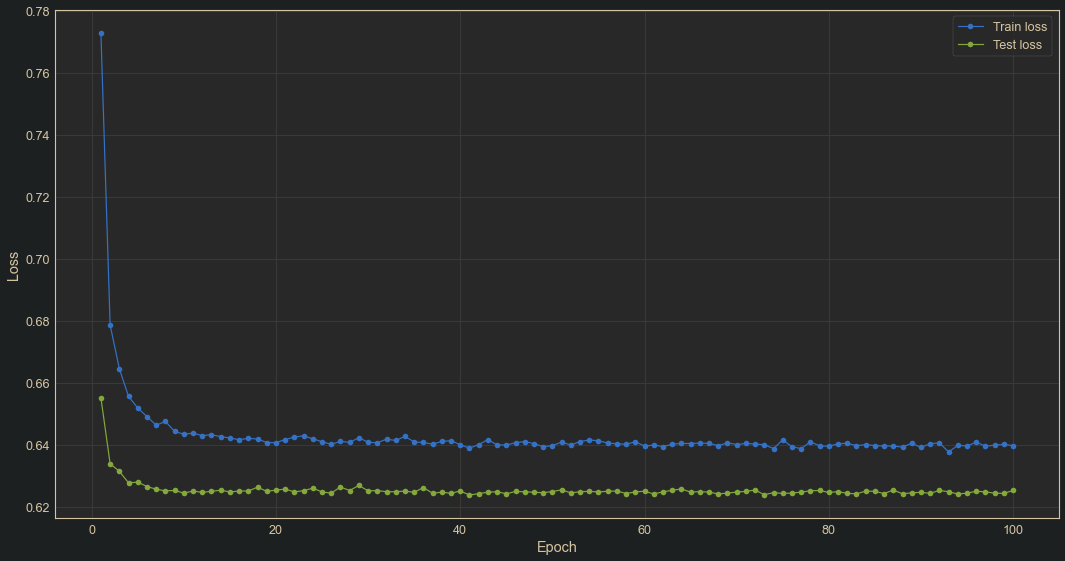

In [54]:
plt.figure(figsize = (15, 8))
plt.plot(range(1, EPOCHS + 1), final_train_loss, label = 'Train loss', marker = 'o')
plt.plot(range(1, EPOCHS + 1), final_test_loss, label = 'Test loss', marker = 'o')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.tight_layout()

plt.show(); plt.close('all')

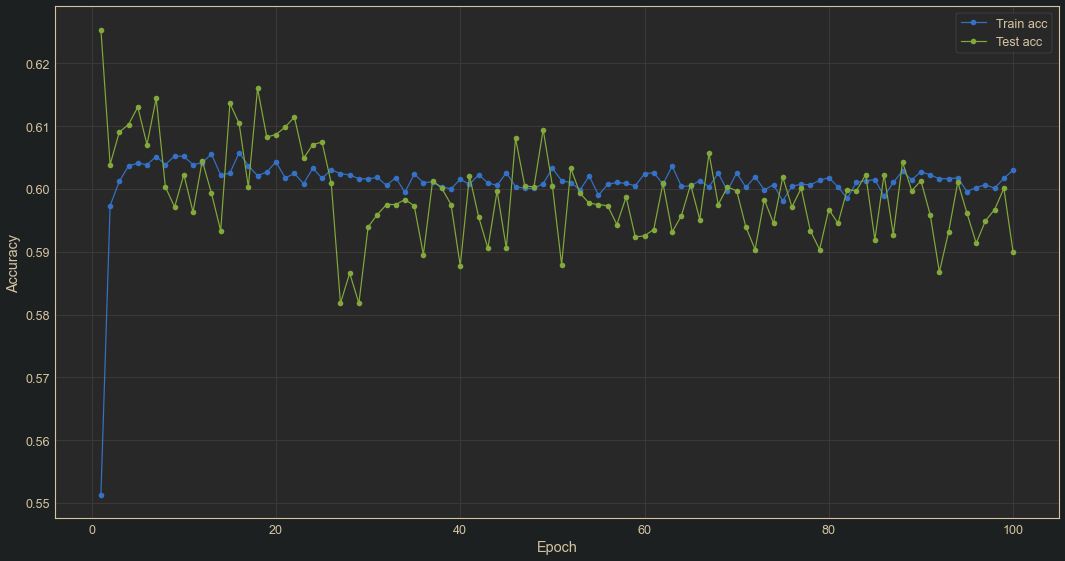

In [57]:
plt.figure(figsize = (15, 8))
plt.plot(range(1, EPOCHS + 1), final_train_acc, label = 'Train acc', marker = 'o')
plt.plot(range(1, EPOCHS + 1), final_test_acc, label = 'Test acc', marker = 'o')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.tight_layout()

plt.show(); plt.close('all')

In [58]:
MODEL_PATH = os.path.join(os.getcwd().replace('notebooks', 'artefacts'), 'saved-model.ckpt')
MODEL_NAME = "saved-model.ckpt"
torch.save(model.state_dict(), MODEL_NAME)